my_dataloader.py

In [ ]:
from torch.utils.data import Dataset
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2


In [ ]:
from google.colab import drive

my_data_dir="Project/archive"

In [ ]:
ls

sample_data/


In [ ]:


drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:


class CrowdDataset(Dataset):
    '''
    crowdDataset
    '''
    def __init__(self,img_root,gt_dmap_root,gt_downsample=1):
        '''
        img_root: the root path of img.
        gt_dmap_root: the root path of ground-truth density-map.
        gt_downsample: default is 0, denote that the output of deep-model is the same size as input image.
        '''
        self.img_root=img_root
        self.gt_dmap_root=gt_dmap_root
        self.gt_downsample=gt_downsample
        #take all file name from root directory and join the filename to path #samples have the overall count of images
        self.img_names=[filename for filename in os.listdir(img_root) \
                           if os.path.isfile(os.path.join(img_root,filename))]
        self.n_samples=len(self.img_names)

    def __len__(self):
        return self.n_samples

    def __getitem__(self,index):
        assert index <= len(self), 'index range error'
        img_name=self.img_names[index]
        img=plt.imread(os.path.join(self.img_root,img_name))
        if len(img.shape)==2: # expand grayscale image to three channel. 2channel to 3channel, tensor
            img=img[:,:,np.newaxis]
            img=np.concatenate((img,img,img),2)

        gt_dmap=np.load(os.path.join(self.gt_dmap_root,img_name.replace('.jpg','.npy')))
        if self.gt_downsample>1: # to downsample image and density-map to match deep-model. if we give downsample more than 1, the size of image reduces, so the below code
            ds_rows=int(img.shape[0]//self.gt_downsample)
            ds_cols=int(img.shape[1]//self.gt_downsample)
            # print(img.type)
            img = cv2.resize(img,(ds_cols*self.gt_downsample,ds_rows*self.gt_downsample))
            img=img.transpose((2,0,1)) # convert to order (channel,rows,cols)
            gt_dmap=cv2.resize(gt_dmap,(ds_cols,ds_rows))
            gt_dmap=gt_dmap[np.newaxis,:,:]*self.gt_downsample*self.gt_downsample

            img_tensor=torch.tensor(img,dtype=torch.float)
            gt_dmap_tensor=torch.tensor(gt_dmap,dtype=torch.float)

        return img_tensor,gt_dmap_tensor



mcnn_model.py

In [ ]:
import torch
import torch.nn as nn


class MCNN(nn.Module):
    '''
    Implementation of Multi-column CNN for crowd counting
    '''
    def __init__(self,load_weights=False):
        super(MCNN,self).__init__()

        self.branch1=nn.Sequential(
            nn.Conv2d(3,16,9,padding=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(16,32,7,padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32,16,7,padding=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(16,8,7,padding=3),
            nn.ReLU(inplace=True)
        )

        self.branch2=nn.Sequential(
            nn.Conv2d(3,20,7,padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(20,40,5,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(40,20,5,padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(20,10,5,padding=2),
            nn.ReLU(inplace=True)
        )

        self.branch3=nn.Sequential(
            nn.Conv2d(3,24,5,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(24,48,3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(48,24,3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(24,12,3,padding=1),
            nn.ReLU(inplace=True)
        )

        self.fuse=nn.Sequential(nn.Conv2d(30,1,1,padding=0))

        if not load_weights:
            self._initialize_weights()

    def forward(self,img_tensor):
        x1=self.branch1(img_tensor)
        x2=self.branch2(img_tensor)
        x3=self.branch3(img_tensor)
        x=torch.cat((x1,x2,x3),1)
        x=self.fuse(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


# test code
if __name__=="__main__":
    img=torch.rand((1,3,800,1200),dtype=torch.float)
    mcnn=MCNN()
    out_dmap=mcnn(img)
    print(out_dmap.shape)

torch.Size([1, 1, 200, 300])


Train.py


In [ ]:
def save_ckp(checkpoint, is_best, checkpoint_path, best_model_path):
  torch.save(checkpoint, checkpoint_path)
  # todo save the best model


In [ ]:
def load_ckp(checkpoint_path, model, optimizer):
  # print(checkpoint_path)
  checkpoint = torch.load(checkpoint_path)
  print(checkpoint['epoch'])
  model.load_state_dict(checkpoint['state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  loss = checkpoint['loss']
  min_epoch = checkpoint['min_epoch']
  return model, optimizer, loss, min_epoch

In [ ]:
import os
import torch
import torch.nn as nn
# import visdom
import random
import re

# from mcnn_model import MCNN
# from my_dataloader import CrowdDataset


if __name__=="__main__":
    torch.backends.cudnn.enabled=False
    # vis=visdom.Visdom()
    device=torch.device("cuda")
    mcnn=MCNN().to(device)
    mcnn=MCNN().to(device)
    criterion=nn.MSELoss(size_average=False).to(device)
    optimizer = torch.optim.SGD(mcnn.parameters(), lr=1e-6,momentum=0.95)
    
    img_root="/content/gdrive/My Drive/"+my_data_dir+"/ShanghaiTech/part_B/train_data/images"
    gt_dmap_root="/content/gdrive/My Drive/"+my_data_dir+"/ShanghaiTech/part_B/train_data/ground-truth"
    dataset=CrowdDataset(img_root,gt_dmap_root,4)
    dataloader=torch.utils.data.DataLoader(dataset,batch_size=1,shuffle=False)
    # dataloader_shuffled = dataloader.dataset.targets
    test_img_root="/content/gdrive/My Drive/"+my_data_dir+"/ShanghaiTech/part_B/test_data/images"
    test_gt_dmap_root="/content/gdrive/My Drive/"+my_data_dir+"/ShanghaiTech/part_B/test_data/ground-truth"
    test_dataset=CrowdDataset(test_img_root,test_gt_dmap_root,4)
    test_dataloader=torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False)

    loaders ={
        'train' : dataloader,
        # 'train' : dataloader_shuffled,
        'test' : test_dataloader
    }

    max_num = 0
    epoch_loss=0
    min_mae=10000
    min_epoch=0
    #training phase
    if not os.path.exists('/content/gdrive/My Drive/Project/archive/checkpointsb_bkp'):
        os.mkdir('/content/gdrive/My Drive/Project/archive/checkpointsb_bkp')

    else:
      os.system("ls '/content/gdrive/My Drive/Project/archive/checkpointsb_bkp' > temp.txt")
      with open("temp.txt","r") as file:
        filenames = file.read()
        # print(filenames)
      filenames = filenames.split('\n')
      filename = []
      for i in range(len(filenames)-1):
        epoching = filenames[i].split('_')
        value = epoching[1]  
        value = value.split('.')
        num = int(value[0])
        if max_num < num:
          max_num = num
      print("Max num:"+str(max_num))
      mcnn, optimizer, epoch_loss, min_epoch = load_ckp('/content/gdrive/My Drive/Project/archive/checkpointsb_bkp/epoch_'+str(max_num)+".pt",mcnn, optimizer)
      min_mae = epoch_loss

    # train_loss_list=[]
    # epoch_list=[]
    test_error_list=[]
    for epoch in range(max_num+1,max_num+2):
                  
        mcnn.train()

        for i,(img,gt_dmap) in enumerate(loaders['train']):
            img=img.to(device)
            gt_dmap=gt_dmap.to(device) 
            # forward propagation
            et_dmap=mcnn(img)
            # plt.imshow(et_dmap)
            # calculate loss
            loss=criterion(et_dmap,gt_dmap)
            epoch_loss+=loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        #print("epoch:",epoch,"loss:",epoch_loss/len(dataloader))
        # epoch_list.append(epoch)
        # train_loss_list.append(epoch_loss/len(dataloader))
        checkpoint = {
            'epoch': epoch,
            'loss': loss.item(),
            'state_dict': mcnn.state_dict(),
            'optimizer': optimizer.state_dict(),
            'min_epoch' : min_epoch,
        }

        # torch.save(mcnn.state_dict(),'/content/gdrive/My Drive/Project/archive/checkpoints/epoch_'+str(epoch)+".param")

        mcnn.eval()
        mae=0
        for i,(img,gt_dmap) in enumerate(loaders['test']):
            img=img.to(device)
            gt_dmap=gt_dmap.to(device)
            # forward propagation
            et_dmap=mcnn(img)
            mae+=abs(et_dmap.data.sum()-gt_dmap.data.sum()).item()
            del img,gt_dmap,et_dmap
        if mae/len(test_dataloader)<min_mae:
            min_mae=mae/len(test_dataloader)
            min_epoch=epoch
        test_error_list.append(mae/len(test_dataloader))
        print("epoch:"+str(epoch)+" error:"+str(mae/len(test_dataloader))+" min_mae:"+str(min_mae)+" min_epoch:"+str(min_epoch))
        checkpoint['min_epoch'] = min_epoch
        checkpoint['loss'] = min_mae
        save_ckp(checkpoint, False, '/content/gdrive/My Drive/Project/archive/checkpointsb_bkp/epoch_'+str(epoch)+".pt", "/")
        # show an image
        index=random.randint(0,len(test_dataloader)-1)
        img,gt_dmap=test_dataset[index]
      
        img=img.unsqueeze(0).to(device)
        gt_dmap=gt_dmap.unsqueeze(0)
        et_dmap=mcnn(img)
        et_dmap=et_dmap.squeeze(0).detach().cpu().numpy()
        


    import time
    print(time.strftime('%Y.%m.%d %H:%M:%S',time.localtime(time.time())))

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Max num:368
368
epoch:369 error:21.44553347780735 min_mae:18.477879522721977 min_epoch:350
2021.05.12 20:57:23


Size after downsampling
(192, 256)


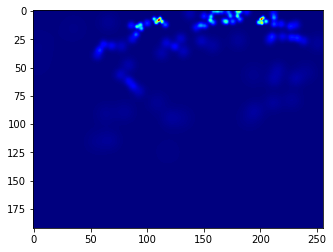

In [ ]:
gt_dmap=gt_dmap.squeeze(0).squeeze(0).cpu().numpy()
print("Size after downsampling")
print(gt_dmap.shape)
import matplotlib.cm as CM
# print(gim.shape)

plt.imshow(gt_dmap,cmap=CM.jet)
# et_dmap=et_dmap.squeeze(0)
# plt.show()
# plt.imshow(et_dmap)

(192, 256)


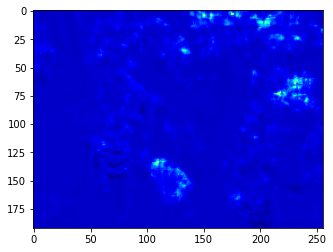

In [ ]:
et_dmap=mcnn(img).detach()
et_dmap=et_dmap.squeeze(0).squeeze(0).cpu().numpy()
print(et_dmap.shape)
plt.imshow(et_dmap,cmap=CM.jet)

In [ ]:
print(type(img))

print(img.shape)

<class 'torch.Tensor'>
torch.Size([1, 3, 768, 1024])


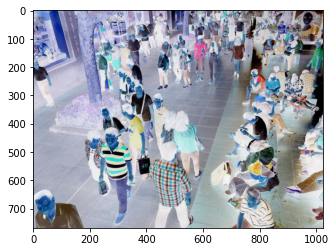

In [ ]:
from torchvision import transforms
squ = np.squeeze(img).cpu()
tensor_to_pil = transforms.ToPILImage()(squ.squeeze(0)) 
plt.imshow(tensor_to_pil)
plt.show()

In [ ]:
# !pip install pillow
# !pip install numpy scipy

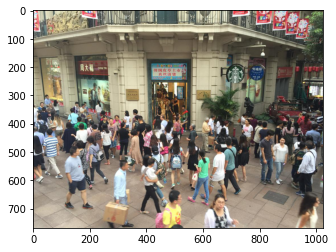

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

im = Image.open('/content/gdrive/My Drive/Project/archive/ShanghaiTech/part_B/train_data/images/IMG_41.jpg')

im
plt.imshow(im)


Actual Image size
768
1024
Size after downsampling
(384, 512)


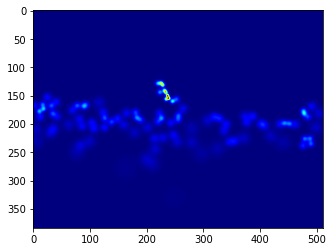

In [ ]:
# img=plt.imread('/content/gdrive/My Drive/Project/archive/ShanghaiTech/part_A/train_data/images/IMG_31.jpg')
# img = np.load('/content/gdrive/My Drive/Project/archive/ShanghaiTech/part_A/train_data/ground-truth/IMG_31.npy')
gt_dmap2=np.load('/content/gdrive/My Drive/Project/archive/ShanghaiTech/part_B/train_data/ground-truth/IMG_41.npy')
# dataset=CrowdDataset(img_root,gt_dmap_root,4)
gt_downsample = 2
print("Actual Image size")
print(gt_dmap2.shape[0])
print(gt_dmap2.shape[1])
ds_rows=int(gt_dmap2.shape[0]//gt_downsample)
ds_cols=int(gt_dmap2.shape[1]//gt_downsample)
# img = cv2.resize(img,(ds_cols*self.gt_downsample,ds_rows*self.gt_downsample))
# img=img.transpose((2,0,1)) # convert to order (channel,rows,cols)
gt_dmap2=cv2.resize(gt_dmap2,(ds_cols,ds_rows))
gt_dmap2=gt_dmap2[np.newaxis,:,:]*gt_downsample*gt_downsample

gt_dmap_tensor=torch.tensor(gt_dmap2,dtype=torch.float)
gt_dmap2=gt_dmap2.squeeze(0)
print("Size after downsampling")
print(gt_dmap2.shape)
import matplotlib.cm as CM
# print(gim.shape)

plt.imshow(gt_dmap2,cmap=CM.jet)

Test set


In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as CM



def cal_mae(img_root,gt_dmap_root,model_param_path):
    '''
    Calculate the MAE of the test data.
    img_root: the root of test image data.
    gt_dmap_root: the root of test ground truth density-map data.
    model_param_path: the path of specific mcnn parameters.
    '''
    device=torch.device("cuda")
    mcnn=MCNN().to(device)
    check_point = torch.load(model_param_path)
    # print(check_point)
    # mcnn.load_state_dict(torch.load(model_param_path))
    mcnn.load_state_dict(check_point['state_dict'])
    dataset=CrowdDataset(img_root,gt_dmap_root,4)
    dataloader=torch.utils.data.DataLoader(dataset,batch_size=1,shuffle=False)
    mcnn.eval()
    mae=0
    with torch.no_grad():
        for i,(img,gt_dmap) in enumerate(dataloader):
            img=img.to(device)
            gt_dmap=gt_dmap.to(device)
            # forward propagation
            et_dmap=mcnn(img)
            mae+=abs(et_dmap.data.sum()-gt_dmap.data.sum()).item()
            del img,gt_dmap,et_dmap

    print("model_param_path:"+model_param_path+" MAE:"+str(mae/len(dataloader)))

def estimate_density_map(img_root,gt_dmap_root,model_param_path,index):
    '''
    Show one estimated density-map.
    img_root: the root of test image data.
    gt_dmap_root: the root of test ground truth density-map data.
    model_param_path: the path of specific mcnn parameters.
    index: the order of the test image in test dataset.
    '''
    device=torch.device("cuda")
    mcnn=MCNN().to(device)
    # mcnn.load_state_dict(torch.load(model_param_path))
    check_point = torch.load(model_param_path)
    # print(check_point)
    # mcnn.load_state_dict(torch.load(model_param_path))
    mcnn.load_state_dict(check_point['state_dict'])
    dataset=CrowdDataset(img_root,gt_dmap_root,4)
    dataloader=torch.utils.data.DataLoader(dataset,batch_size=1,shuffle=False)
    mcnn.eval()
    for i,(img,gt_dmap) in enumerate(dataloader):
        if i==index:
            img=img.to(device)
            gt_dmap=gt_dmap.to(device)
            # forward propagation
            et_dmap=mcnn(img).detach()
            et_dmap=et_dmap.squeeze(0).squeeze(0).cpu().numpy()
            print(et_dmap.shape)
            plt.imshow(et_dmap,cmap=CM.jet)
            break


if __name__=="__main__":
    torch.backends.cudnn.enabled=False
    img_root='/content/gdrive/My Drive/Project/archive/ShanghaiTech/part_B/test_data/images'
    gt_dmap_root='/content/gdrive/My Drive/Project/archive/ShanghaiTech/part_B/test_data/ground-truth'
    model_param_path='/content/gdrive/My Drive/Project/archive/checkpointsb/epoch_462.pt'

bacteria


In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as CM
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def estimate_density_map_bacteria(img_root_b,model_param_path_b,img_name):

#####################3
    # img_name='IMG_51.jpg'
    # img_name='361.png'
    # img_name='011128.jpg'
    img=plt.imread(os.path.join(img_root_b,img_name))
    # print(img.type)
    # img=torch.rand((1,3,800,1200),dtype=torch.float)
    if len(img.shape)==2: # expand grayscale image to three channel. 2channel to 3channel, tensor
        img=img[:,:,np.newaxis,np.newaxis]
        img=np.concatenate((img,img,img,img),2)
        # img_tensor=torch.tensor(img,dtype=torch.float)
    # print(img.type)
    gt_downsample = 4
    if gt_downsample>=1: # to downsample image and density-map to match deep-model. if we give downsample more than 1, the size of image reduces, so the below code
        ds_rows=int(img.shape[0]//gt_downsample)
        ds_cols=int(img.shape[1]//gt_downsample)
        # gray = cv2.cvtColor(cv2.UMat(img,2), cv2.COLOR_RGB2GRAY)
        # print(img.type)
        img = cv2.resize(img,(ds_cols*gt_downsample,ds_rows*gt_downsample))
        # print(img.shape)
        img=img.transpose((2,0,1)) # convert to order (channel,rows,cols)
        # img=torch.rand((1,3,800,1200),dtype=torch.float)
        # print(img.shape)
        img = np.expand_dims(img, axis=0)
        img_tensor=torch.tensor(img,dtype=torch.float)
        # print(img_tensor)
        img = img_tensor
#######################
    im = Image.open(os.path.join(img_root_b,img_name))

    # im
    plt.imshow(im)
    plt.show()

    device=torch.device("cuda")
    mcnn=MCNN().to(device)
    check_point = torch.load(model_param_path_b)
    mcnn.load_state_dict(check_point['state_dict'])
    mcnn.eval()

    img = img.to(device)
    et_dmap=mcnn(img).detach()
    et_dmap=et_dmap.squeeze(0).squeeze(0).cpu().numpy()
    # print(et_dmap.shape)
    plt.imshow(et_dmap,cmap=CM.jet)
    plt.show()

if __name__=="__main__":
    torch.backends.cudnn.enabled=False
    # img_root_b='/content/gdrive/My Drive/Project/archive/ShanghaiTech/part_B/test_data/images'
    # img_root_b='/content/gdrive/My Drive/Project/archive/bacteria/bacteria/images/'
    # img_root_b='/content/gdrive/My Drive/Project/archive/bacteria/Highway_Dataset/images/'
    model_param_path_b='/content/gdrive/My Drive/Project/archive/checkpoints/epoch_647.pt'

In [ ]:
def print_groundtruth(val):
  # val = '/content/gdrive/My Drive/Project/archive/ShanghaiTech/part_B/train_data/ground-truth/'+str(name)
  gt_dmap2=np.load(val)

  gt_downsample = 2

  ds_rows=int(gt_dmap2.shape[0]//gt_downsample)
  ds_cols=int(gt_dmap2.shape[1]//gt_downsample)

  gt_dmap2=cv2.resize(gt_dmap2,(ds_cols,ds_rows))
  gt_dmap2=gt_dmap2[np.newaxis,:,:]*gt_downsample*gt_downsample

  gt_dmap_tensor=torch.tensor(gt_dmap2,dtype=torch.float)
  gt_dmap2=gt_dmap2.squeeze(0)
  print("Actual ground truth")
  
  import matplotlib.cm as CM

  plt.imshow(gt_dmap2,cmap=CM.jet)

(768, 1024, 3)
(3, 768, 1024)
tensor([[[[179., 178., 178.,  ...,  41.,  46.,  69.],
          [179., 178., 178.,  ...,  43.,  47.,  65.],
          [179., 179., 178.,  ...,  45.,  45.,  61.],
          ...,
          [ 91.,  86.,  79.,  ..., 120., 118., 113.],
          [ 95.,  91.,  82.,  ..., 116., 116., 112.],
          [ 96.,  92.,  84.,  ..., 113., 114., 113.]],

         [[164., 163., 163.,  ...,  65.,  72.,  95.],
          [164., 163., 163.,  ...,  68.,  71.,  91.],
          [164., 164., 163.,  ...,  70.,  70.,  86.],
          ...,
          [ 75.,  73.,  67.,  ..., 126., 124., 119.],
          [ 78.,  75.,  70.,  ..., 122., 122., 118.],
          [ 79.,  76.,  72.,  ..., 119., 120., 119.]],

         [[125., 124., 124.,  ...,  99., 105., 128.],
          [125., 124., 124.,  ...,  99., 105., 124.],
          [125., 125., 124.,  ..., 100., 100., 116.],
          ...,
          [ 59.,  57.,  55.,  ..., 126., 124., 119.],
          [ 62.,  60.,  58.,  ..., 122., 122., 118.],
   

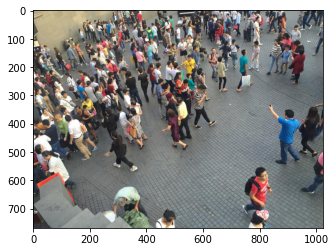

(192, 256)


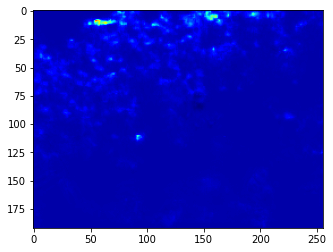

In [ ]:
# cal_mae(img_root,gt_dmap_root,model_param_path)
estimate_density_map_bacteria(img_root_b,model_param_path_b)

Actual image and model's estimate


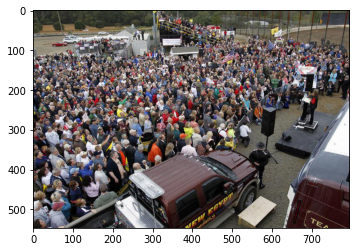

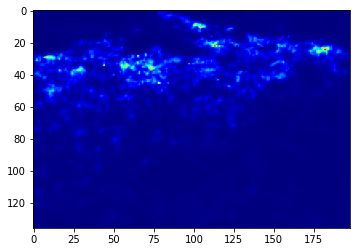

Actual ground truth


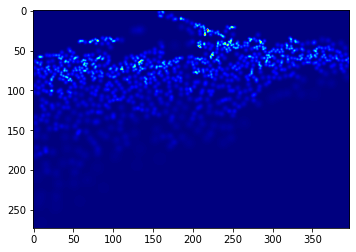

In [ ]:
# cal_mae(img_root,gt_dmap_root,model_param_path)
print("Actual image and model's estimate")
# estimate_density_map_bacteria('/content/gdrive/My Drive/Project/archive/ShanghaiTech/part_B/test_data/images','/content/gdrive/My Drive/Project/archive/checkpointsb_bkp/epoch_350.pt','IMG_132.jpg')
estimate_density_map_bacteria('/content/gdrive/My Drive/Project/archive/ShanghaiTech/part_A/test_data/images','/content/gdrive/My Drive/Project/archive/checkpointsb_bkp/epoch_350.pt','IMG_130.jpg')
print_groundtruth('/content/gdrive/My Drive/Project/archive/ShanghaiTech/part_A/test_data/ground-truth/IMG_130.npy')
